In [1]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('../01_preprocess/preprocessed.csv')
# Calculate the percentile brackets
df['percentile bracket'] = pd.qcut(df['time'], q=10, labels=False, duplicates='drop') + 1

df.drop(['cycle', 'instr', 'LLC_miss','CPU','L1_miss', 'br_miss', 'scale', 'counted_final_key_count', 'GHz', 'time', 'task', 'IPC'], axis=1, inplace=True)
df.head()

,config_name,const_basicHintCount,const_enableBasicHead,const_enableDense,const_enableDense2,const_enableDensifySplit,const_enableHash,const_enableHashAdapt,const_enableHeadNode,const_enablePrefix,...,ycsb_range_len,ycsb_zipf,nodeCount_Leaf,nodeCount_Inner,nodeCount_Dense,nodeCount_Hash,nodeCount_Head4,nodeCount_Head8,nodeCount_Dense2,percentile bracket
0,hash,16,1,0,0,0,1,0,0,1,...,100,1.133614,0,846,0,121433,0,0,0,5
1,hash,16,1,0,0,0,1,0,0,1,...,100,1.133614,0,846,0,121433,0,0,0,4
2,dense3,16,1,1,0,1,0,0,0,1,...,100,0.316120,38703,270,0,0,0,0,0,3
3,dense3,16,1,1,0,1,0,0,0,1,...,100,0.316120,38703,270,0,0,0,0,0,8
4,hints,16,1,0,0,0,0,0,0,1,...,100,0.666485,27850,742,0,0,0,0,0,6


In [2]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(['object']).columns

print("Number of columns:", df.shape[1])

# Apply one-hot encoding to non-numeric columns
df = pd.get_dummies(df, columns=non_numeric_columns)

print("Number of columns after one-hot:", df.shape[1])

Number of columns: 35
Number of columns after one-hot: 40


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('percentile bracket', axis=1), df['percentile bracket'], test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the percentile brackets for the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.6515591007976794

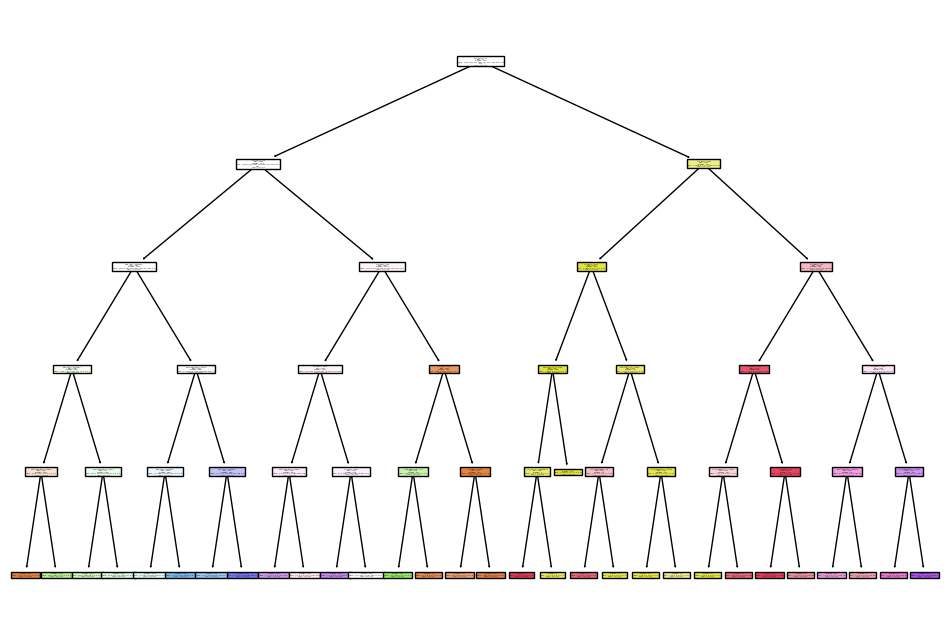

In [9]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Convert percentile bracket to strings
df['percentile bracket'] = df['percentile bracket'].astype(str)+"0%"

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=df.drop('percentile bracket', axis=1).columns, class_names=df['percentile bracket'].unique(), filled=True)
plt.show()


In [10]:
from sklearn import tree
text_representation = tree.export_graphviz(clf, feature_names=df.drop('percentile bracket', axis=1).columns, class_names=df['percentile bracket'].unique(), filled=True, out_file="tree.dot")


In [4]:
input_data=pd.read_csv('../01_preprocess/shap_raw.csv')
# Identify non-numeric columns
non_numeric_columns = input_data.select_dtypes(['object']).columns

print("Number of columns:", input_data.shape[1])

# Apply one-hot encoding to non-numeric columns
input_data = pd.get_dummies(input_data, columns=non_numeric_columns)

print("Number of columns after one-hot:", input_data.shape[1])

Number of columns: 34
Number of columns after one-hot: 39


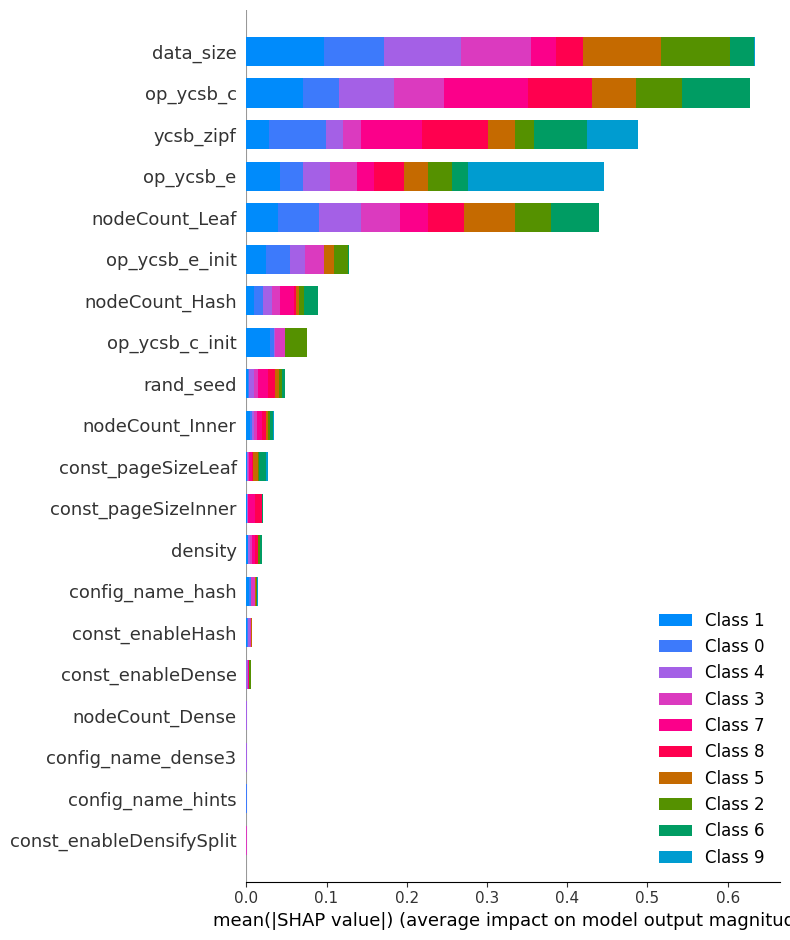

In [5]:
import shap
explainer = shap.Explainer(clf)

shap_values = explainer.shap_values(input_data)
shap.summary_plot(shap_values, input_data)